In [13]:
from pathlib import Path

import numpy as np
import pandas as pd
from transformers import BertTokenizer
import torch.nn.functional as F
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm, wilcoxon, ttest_rel

In [25]:
MODELS = ['bert-base-multilingual-uncased', 'bert-base-uncased', 'bert-large-uncased', 'runs/Dec10_09-36-11_elm22', 'runs/Dec09_23-04-25_elm22', 'runs/Dec09_23-11-05_elm14','runs/Dec10_00-20-49_elm22', 'models/rmsle_less_loss_lr_1e-6_aug_data_epoch_10_no_warmup']
target_path = Path('runs') / 'crows_pairs/data/crows_pairs_anonymized.csv'

--- bert-base-multilingual-uncased ---
-31.35603381962865 -31.78448806366048
Ttest_relResult(statistic=-3.769306422117954, pvalue=0.00017001923563099243)
WilcoxonResult(statistic=473787.0, pvalue=1.8752541249851216e-08)
--- bert-base-uncased ---
-26.02256100795756 -26.613938328912468
Ttest_relResult(statistic=-4.377205986556729, pvalue=1.2848758026769643e-05)
WilcoxonResult(statistic=437365.0, pvalue=7.450508167014153e-15)
--- bert-large-uncased ---
-24.49763527851459 -25.29444098143236
Ttest_relResult(statistic=-5.826720760642852, pvalue=6.90006915357158e-09)
WilcoxonResult(statistic=421711.0, pvalue=3.256925206403262e-18)
--- runs/Dec10_09-36-11_elm22 ---
-25.867731432360745 -26.254266578249332
Ttest_relResult(statistic=-3.0176901629010326, pvalue=0.0025898026594152893)
WilcoxonResult(statistic=471823.0, pvalue=9.509424447044416e-09)
--- runs/Dec09_23-04-25_elm22 ---
-26.532376657824933 -27.03651392572944
Ttest_relResult(statistic=-4.066866269339282, pvalue=5.0112548819969645e-05)
Wi

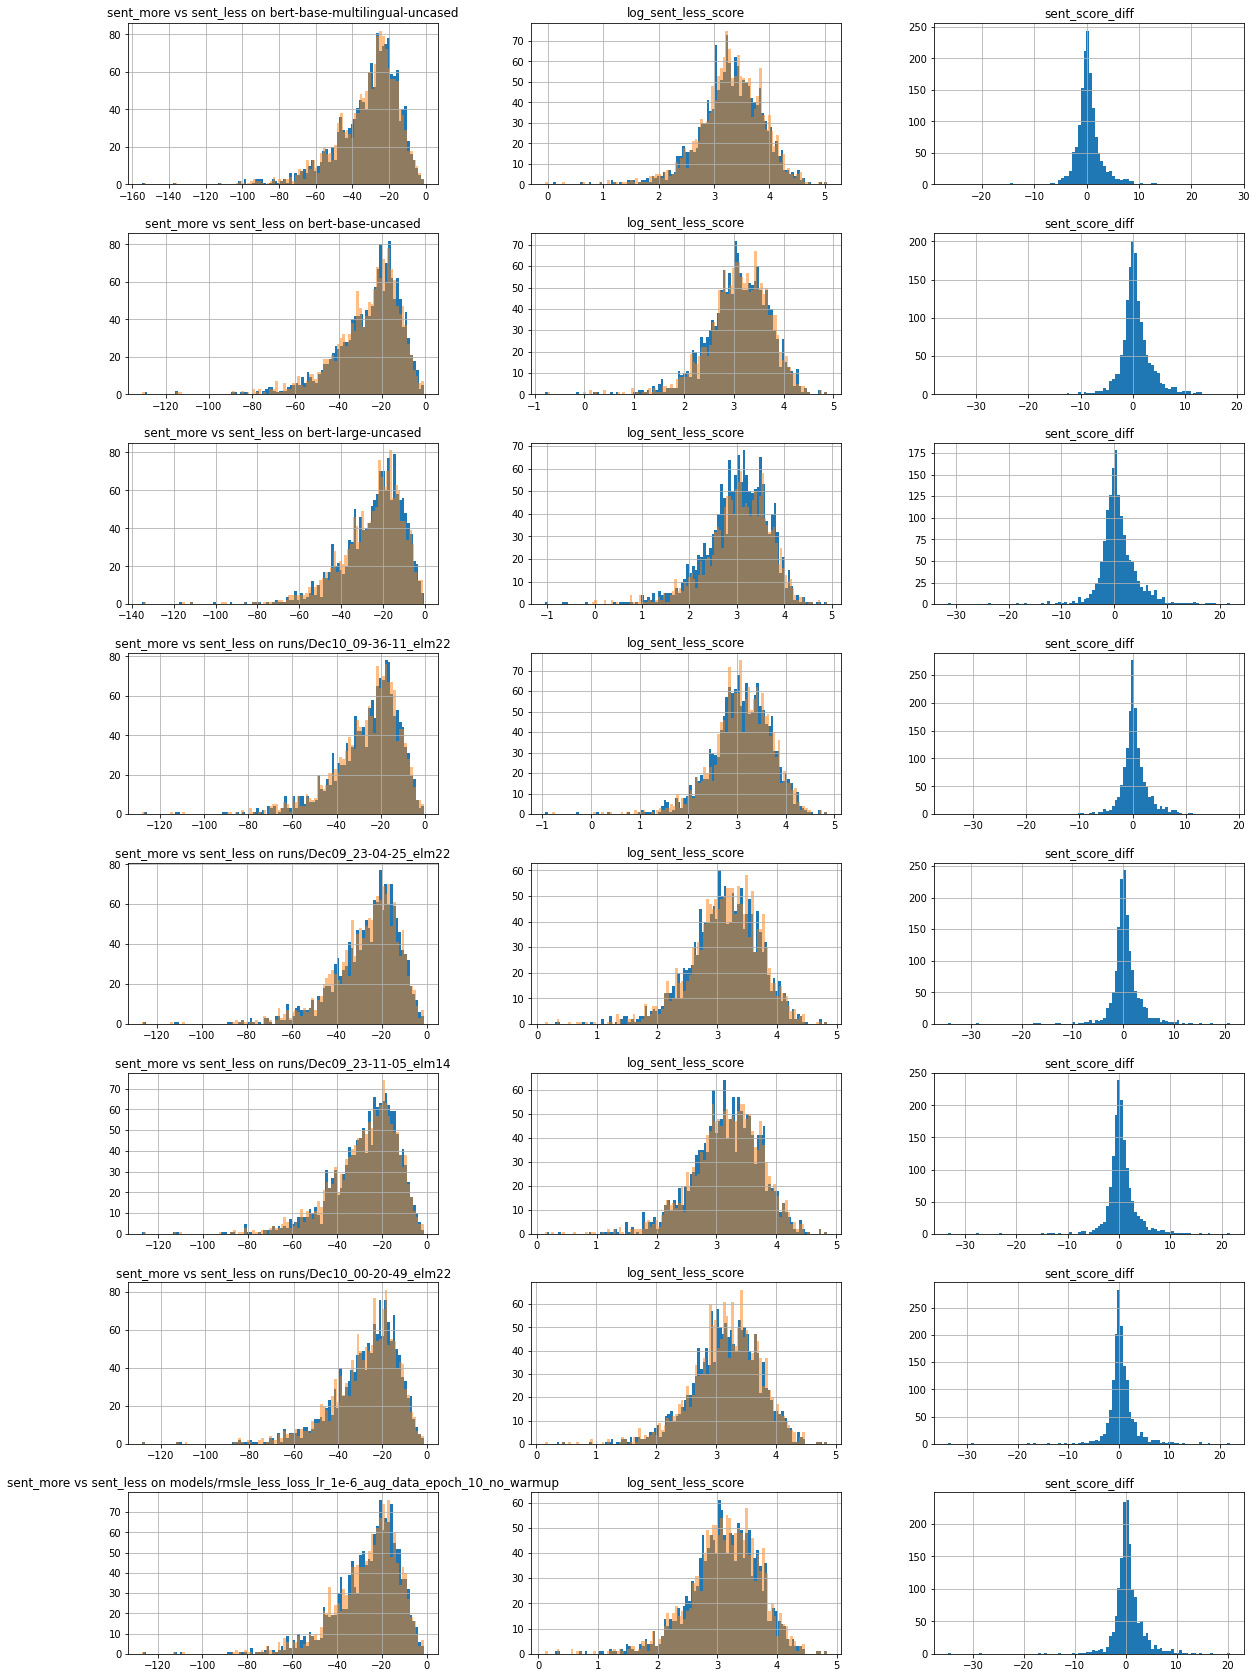

In [26]:
fig, ax = plt.subplots(len(MODELS), 3, figsize=[20.0, 30.0])

# indeces = range(0, 1508)
# indeces = np.random.choice(indeces, 500)

df_dict = {}
for n, model in enumerate(MODELS):
    print(f'--- {model} ---')
    df_dict[model] = pd.read_csv(target_path / model / 'results.csv')
    df = df_dict[model]# .iloc[indeces]
    print(df['sent_more_score'].mean(), df['sent_less_score'].mean())
    df['sent_score_diff'] = df['sent_more_score'] - df['sent_less_score']
    df['log_sent_more_score'] = np.log(-df['sent_more_score'])
    df['log_sent_less_score'] = np.log(-df['sent_less_score'])
    t_result = ttest_rel(df['log_sent_more_score'], df['log_sent_less_score'])
    print(t_result)
    w_result = wilcoxon(df['sent_more_score'], df['sent_less_score'], zero_method='zsplit', correction=True)
    print(w_result)

    df.hist('sent_more_score', ax=ax[n][0], bins=100)
    df.hist('sent_less_score', ax=ax[n][0], bins=100, alpha=.5)

    df.hist('log_sent_more_score', ax=ax[n][1], bins=100)
    df.hist('log_sent_less_score', ax=ax[n][1], bins=100, alpha=.5)
    df.hist('sent_score_diff', ax=ax[n][2], bins=100)
    ax[n][0].set_title(f'sent_more vs sent_less on {model}')

# 考察
* 尤度変わりすぎじゃね？（BERT non-ml vs ml, base vs large)に比べても...
  * 割と悪影響している説
     * 元のBERTが出力する尤度から変わらないように制約すべき？